In [1]:
# Downloading the clevr dataset takes about 5-7 min
!wget https://dl.fbaipublicfiles.com/clevr/CLEVR_v1.0.zip
# unzip the file takes about 3 min
!unzip -q CLEVR_v1.0.zip

--2022-04-30 01:59:43--  https://dl.fbaipublicfiles.com/clevr/CLEVR_v1.0.zip
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.74.142, 104.22.75.142, 172.67.9.4, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.74.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19021600724 (18G) [application/zip]
Saving to: ‘CLEVR_v1.0.zip’

CLEVR_v1.0.zip      100%[===================>]  17.71G  34.5MB/s    in 10m 30s 

2022-04-30 02:10:14 (28.8 MB/s) - ‘CLEVR_v1.0.zip’ saved [19021600724/19021600724]



In [134]:
import numpy as np
import os
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
from torchvision import datasets, transforms
from PIL import Image
import torch, os, json
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.models as models
from torchvision.transforms.transforms import Resize
import seaborn as sns
from torchvision.utils import save_image

torch.manual_seed(42)

In [4]:
# Installing the transformer library

!pip -q install transformers

from transformers import MobileBertTokenizer, MobileBertForSequenceClassification,BertTokenizer

     |████████████████████████████████| 4.0 MB 5.1 MB/s 
     |████████████████████████████████| 596 kB 55.5 MB/s 
     |████████████████████████████████| 6.6 MB 66.4 MB/s 
     |████████████████████████████████| 77 kB 6.0 MB/s 
     |████████████████████████████████| 895 kB 53.4 MB/s 


In [5]:
class CLEVER(torch.utils.data.Dataset):
    def __init__(self,categories = None,folder = 'CLEVR_v1.0/', split = "train",transformation = None):
        self.json_dir = os.path.join(folder,'questions',f"CLEVR_{split}_questions.json")
        self.image_dir = os.path.join(folder,'images',split)
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        self.categories = categories
        self.data = []
        self.cat2id = {i:index for index,i in enumerate(categories)}
        self.id2cat = {index:i for index,i in enumerate(categories)}
        self.transformation = transformation
        self.json_file = json.load(open(self.json_dir))
        
        for index,i in enumerate(self.json_file["questions"][:10000]):
            text = i["question"]
            answer = self.cat2id[i["answer"]]
            label_vector = torch.zeros((len(self.categories)))
            label_vector[answer] = 1
            self.data.append((i["image_index"],i["image_filename"],text,label_vector))
    
    def __getitem__(self,index):
        image_path = os.path.join(self.image_dir,self.data[index][1])
        image = Image.open(image_path).convert('RGB')
        if self.transformation != None:
            image = self.transformation(image)
        text = self.data[index][2]
        encoded_text = self.tokenizer.encode_plus(
                text, add_special_tokens = True, truncation = True, 
                max_length = 256, padding = 'max_length',
                return_attention_mask = True,
                return_tensors = 'pt')
        text = encoded_text['input_ids'][0]
        attention_mask = encoded_text['attention_mask'][0]
        answer = self.data[index][3]
        return image,text,attention_mask,answer

    def __len__(self):
        return len(self.data[:10000])

In [6]:

categories = ['0', '1', '10', '2', '3', '4', '5', '6', '7', '8', '9', 'blue', 'brown', 'cube', 'cyan', 'cylinder', 'gray', 'green', 'large', 'metal', 'no', 'purple', 'red', 'rubber', 'small', 'sphere', 'yellow', 'yes']
categories = list(sorted(categories))
print(categories)

norm = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
transform_train = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
    norm,
])
transform_test = transforms.Compose([
            transforms.Resize((128,128)),
            transforms.ToTensor(),
            norm,
        ])
train_data = CLEVER(categories = categories,split = 'train',transformation = transform_train)
valid_data = CLEVER(categories = categories,split = 'val',transformation = transform_test)

['0', '1', '10', '2', '3', '4', '5', '6', '7', '8', '9', 'blue', 'brown', 'cube', 'cyan', 'cylinder', 'gray', 'green', 'large', 'metal', 'no', 'purple', 'red', 'rubber', 'small', 'sphere', 'yellow', 'yes']


Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [7]:
class custom_model(nn.Module):
    def __init__(self,categories):
        super(custom_model, self).__init__()

        self.bert = MobileBertForSequenceClassification.from_pretrained("google/mobilebert-uncased", 
        num_labels = 1000,  output_attentions = False, 
        output_hidden_states = False)

        self.cnn = models.resnet18(pretrained = True)

        self.linear1 = torch.nn.Linear(2000,1028)
        self.linear2 = torch.nn.Linear(1028,28)
        

    def forward(self,image_data,text_data,text_masks):
        x1 = self.cnn(image_data)
        x2 = self.bert(text_data,text_masks)
        x = torch.cat((x1,x2.logits),dim = 1)
        x = self.linear1(x)
        x = self.linear2(x)
       
        return x

In [14]:
model = custom_model(categories)
model = model.to("cpu")
model.load_state_dict(torch.load("trained_model.pth",map_location=torch.device("cpu")))
model.eval()

Some weights of the model checkpoint at google/mobilebert-uncased were not used when initializing MobileBertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.dense.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing MobileBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing MobileBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some 

custom_model(
  (bert): MobileBertForSequenceClassification(
    (mobilebert): MobileBertModel(
      (embeddings): MobileBertEmbeddings(
        (word_embeddings): Embedding(30522, 128, padding_idx=0)
        (position_embeddings): Embedding(512, 512)
        (token_type_embeddings): Embedding(2, 512)
        (embedding_transformation): Linear(in_features=384, out_features=512, bias=True)
        (LayerNorm): NoNorm()
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (encoder): MobileBertEncoder(
        (layer): ModuleList(
          (0): MobileBertLayer(
            (attention): MobileBertAttention(
              (self): MobileBertSelfAttention(
                (query): Linear(in_features=128, out_features=128, bias=True)
                (key): Linear(in_features=128, out_features=128, bias=True)
                (value): Linear(in_features=512, out_features=128, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): M

In [15]:
def inverse_normalize(tensor, mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]):
    tcopy = tensor.clone()
    for t, m, s in zip(tcopy, mean, std):
        t.mul_(s).add_(m)
    return tcopy

In [86]:
def get_results(number):
    # getting the data ready
    q_no = number
    img,text,attention,answer = valid_data[q_no]
    img = img.unsqueeze(0)
    text = text.unsqueeze(0)
    attention = attention.unsqueeze(0)

    # displaying the image
    plt.figure(figsize = (6,6))
    plt.imshow(inverse_normalize(img.cpu()).data[0].clip(0, 1).permute(1, 2, 0))
    plt.grid('off'); plt.axis('off');

    # The question asked is
    print(valid_data.json_file["questions"][q_no]["question"])

    # The model result is
    with torch.no_grad():
        prediction = torch.nn.Softmax(dim = 1)(model(img,text,attention))
        pred = torch.topk(prediction,5).indices
        for i in pred[0]:
            p = valid_data.id2cat[int(i)]
            print("Prediction : ", p, "                 Confidence : ", round(prediction[0][i].item(),2))
    

Is there a big brown object of the same shape as the green thing?
Prediction :  yes                  Confidence :  0.61
Prediction :  no                  Confidence :  0.38
Prediction :  large                  Confidence :  0.0
Prediction :  0                  Confidence :  0.0
Prediction :  brown                  Confidence :  0.0


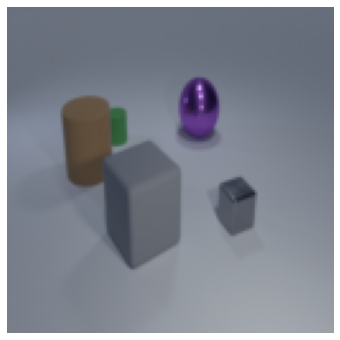

In [87]:
get_results(1)

Do the small shiny object and the matte cylinder have the same color?
Prediction :  yes                  Confidence :  0.61
Prediction :  no                  Confidence :  0.39
Prediction :  0                  Confidence :  0.0
Prediction :  2                  Confidence :  0.0
Prediction :  brown                  Confidence :  0.0


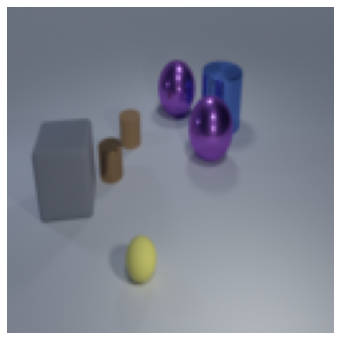

In [90]:
get_results(30)

What is the shape of the tiny object that is to the left of the tiny thing that is in front of the tiny cylinder in front of the brown cylinder?
Prediction :  sphere                  Confidence :  0.55
Prediction :  cylinder                  Confidence :  0.24
Prediction :  cube                  Confidence :  0.2
Prediction :  yes                  Confidence :  0.0
Prediction :  rubber                  Confidence :  0.0


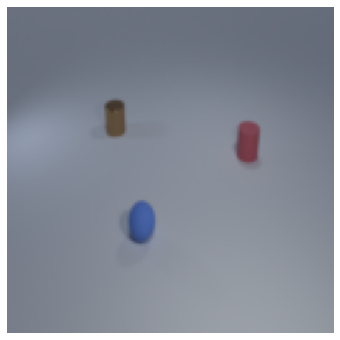

In [95]:
get_results(169)

### Results with different models

## The top 1 result of our trained models



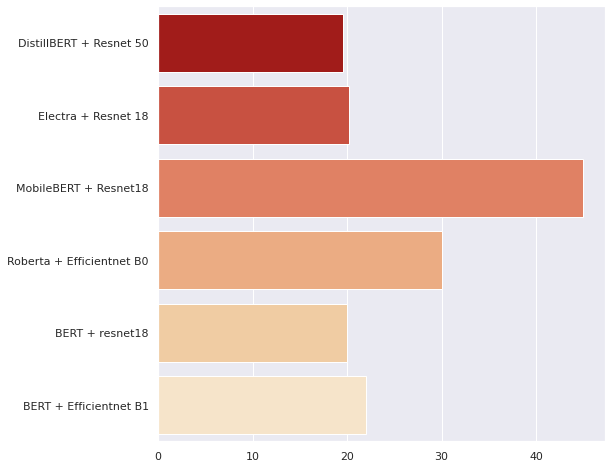

In [150]:
models = ["DistillBERT + Resnet 50", "Electra + Resnet 18","MobileBERT + Resnet18", "Roberta + Efficientnet B0", "BERT + resnet18", "BERT + Efficientnet B1"]
valid_accuracy = [19.6,20.15,45,30,20,22 ]

sns.set_theme()
plt.figure(figsize= (8,8))
sns.barplot(x = valid_accuracy,y = models,orient = "h",palette = "OrRd_r")

plt.savefig("Results.jpg",format="pdf", bbox_inches="tight")

## The top 5 results of our models

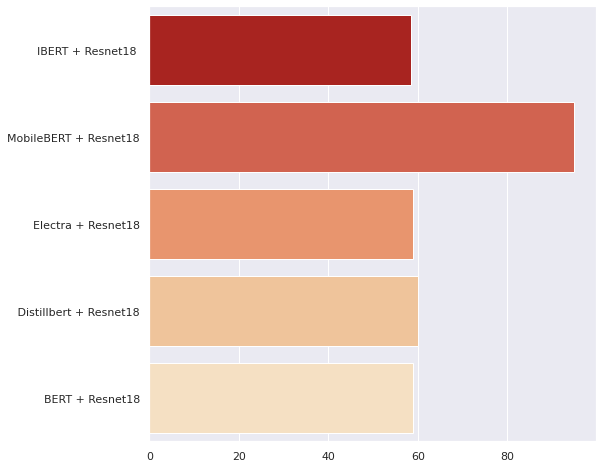

In [151]:
models = ["IBERT + Resnet18 ", "MobileBERT + Resnet18","Electra + Resnet18", " Distillbert + Resnet18", "BERT + Resnet18"]
valid_accuracy = [58.4,95,59,60,59]

sns.set_theme()
plt.figure(figsize= (8,8))
sns.barplot(x = valid_accuracy,y = models,orient = "h",palette = "OrRd_r")

plt.savefig("Top5.pdf", format="pdf", bbox_inches="tight")